In [9]:
from zhinst.core import ziDAQServer
from zhinst.toolkit.nodetree.helper import NodeDict
import matplotlib as mpl
from allantools import oadev, noise
import numpy as np
import pickle
import os
import datetime
from itertools import chain
import matplotlib.pyplot as plt

daq = ziDAQServer('10.209.64.46', 8004, 6)

In [10]:
pid = daq.pidAdvisor()

from zhinst.toolkit import PIDMode


In [11]:
daq.connectDevice("DEV6293", "PCIe")

# Relevant numbers are /DEV6293/DEMODS/0/FREQ and /DEV6293/DEMODS/0/FREQ/SAMPLE

# from API daq_module.subscribe('/dev6293/demods/0/sample.xiy.fft.abs.filter') -> 0-based indexing
# from me: daq_module.subscribe('/dev6293/demods/0/sample.freq')
# -> we can poll the entire .../sample node - see ZHINST Allan Variance
# -> data is pushed from MFLI to data server by subscribing to node daq.subscribe(node)
# data is pushed from data server to client by poll - daq.poll(self, recording_time_s, timeout_ms, flags=0, flat=False)

In [4]:
"/dev6293/pids/0/stream/value"

'/dev6293/pids/0/stream/value'

In [12]:
time_meas= 60 #Define the total measurement time in [s]
save_dir = r"C:\Users\SLAB2\Documents\Leo_Thesis_Data\interferometer_characterization\time_series_MFLI_2605"

def poll_custom(demod_index):
    # subscribe to the demodulator poll node
    poll_node = "/dev6293/demods/0/sample"
    # poll_node = "/dev6293/pids/0/stream/value"
    

    try:
        daq.subscribe(poll_node)
        
        # Poll the subscribed data from the data server. Poll will block and record
        # for poll_length seconds.
        total_length = time_meas # [s] # It will have to looped for the measurement
        poll_length = 1 # [s]
        poll_timeout = 1  # [ms]

        numbofPolls = int(np.ceil(total_length/poll_length))

        ij=1
        for i_poll in range(numbofPolls):        
            data_i= daq.poll(recording_time_s=poll_length, timeout_ms=poll_timeout)      
            data_i_poll = data_i["dev6293"]["demods"]["0"]["sample"]
            # data_i_poll = data_i["dev6293"]["pids"]["0"]["stream"]["value"]
            # data_i = NodeDict(data_i)
            
            fp = os.path.join(save_dir, "%s.dat" % ij)
            file = open(fp,'wb')
            ij=ij+1
            pickle.dump(data_i_poll, file)
            file.close()
    finally:
        daq.unsubscribe(poll_node)

    # get instrument's timebase (min. distance between two timestamps, equal to 1/max. sampling rate  
    timebase = daq.getDouble("/DEV6293/SYSTEM/PROPERTIES/TIMEBASE")

    return timebase

#Function to convert timestamp to real time

def timestamp_to_elapstime(timestamp, timebase):
    timestamp = timestamp - timestamp[0]
    elapstime = timestamp*timebase
    return elapstime

In [13]:
# Call the function to poll the data
# what happens is that we poll for a 1 second with a time_out in between in a total of five times 

timebase=poll_custom(0)
print('Aquisition Complete')

Aquisition Complete


In [14]:
now = datetime.date.today()  
ij = 1

# Prepare the Data structure array to write the data

Data = {'frequency':[],'x':[],'y':[], 'elapsedtime':[]}

for ii in range(time_meas):
    fp = os.path.join(save_dir, "%s.dat" % ij)
    file=open(fp,'rb')
    data_i_poll = pickle.load(file)
    
    Data['elapsedtime'].append(data_i_poll['timestamp'])
    Data['frequency'].append(data_i_poll['frequency'])
    Data['x'].append(data_i_poll['x'])
    Data['y'].append(data_i_poll['y'])
    file.close()
    ij=ij+1

    
Data['elapsedtime']=np.array(list(chain.from_iterable(Data['elapsedtime'])))
Data['x']=np.array(list(chain.from_iterable(Data['x'])))
Data['y']=np.array(list(chain.from_iterable(Data['y'])))
Data['frequency']=np.array(list(chain.from_iterable(Data['frequency'])))

Data['elapsedtime'] = timestamp_to_elapstime(Data['elapsedtime'] , timebase)
time0=Data['elapsedtime'][1]

26786.0


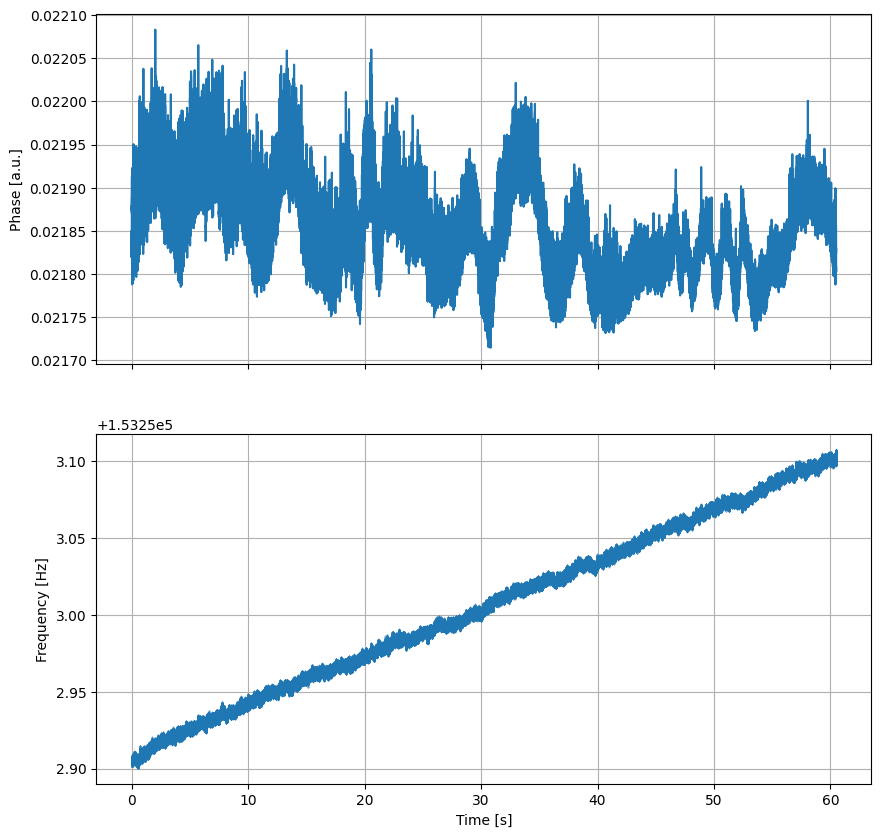

In [15]:
# using a subplot structure for the plot
phase = np.arctan(Data["y"], Data["x"])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,10))

ax1.plot(Data['elapsedtime'], phase, label="Phase [deg]")
ax1.set_ylabel("Phase [a.u.]")
ax1.grid(True)

ax2.plot(Data["elapsedtime"], Data["frequency"], ".", label="Frequency [a.u.]", ms=0.5)
ax2.grid(True)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")

# Calculate sampling rate
rate = Data['elapsedtime'][1:-1]-Data['elapsedtime'][0:-2] # get difference

# rate = np.round(1/rate[0]) #[Hz]   
rate = np.round(1/rate[0])

Data['rate'] = rate # matches rate from lock-in data transfer window (104.6)
print(rate)

In [8]:
# Allan Deviation for phase
taus = np.logspace(-4,time_meas,20_000)
t2, aldev, _, _ = oadev(phase, data_type='phase', rate=rate, taus=taus)

In [27]:
# what Aida is using
freq_mean = Data["frequency"].mean()
freq_frac = (Data["frequency"] - freq_mean) / freq_mean
taus = np.logspace(-4,time_meas,20_000)

t2, aldev, _, _ = oadev(freq_frac, data_type='freq', rate=rate, taus=taus)

In [10]:
print(aldev)

[8.25109762e-02 7.11103303e-02 6.07587154e-02 ... 2.45144119e-06
 2.91157049e-06 2.32187843e-06]


In [28]:
data_plot["20Hz"] = aldev

In [40]:
noise_white = noise.white(len(freq_frac), b0=1E-17, fs=rate)        # Frequency noise white with same sample rate and num. data points as fract. freq. values
t2_noise, aldev_noise, _, _ = oadev(noise_white, data_type="freq", rate=rate, taus=taus)

# plt.plot(noise_white)

In [297]:
# get thermal noise
def ad_theory(f, tau, tau_thermal=0.055, noise_floor=5E-18):
    return np.sin((np.pi*f*tau)**4) / ((2*np.pi*f)**2 * np.abs(1 / 1 + (2*np.pi*tau_thermal*f))**2 * noise_floor)
    
from scipy.integrate import quad

# Perform the numerical integration from f = 0 to f = infinity
# result, error = quad(ad_theory, 0, np.inf, args=(1, ))
taus_thermal = taus[::20]

result_list = []
for tt in taus_thermal:
    result, error = quad(ad_theory, 0, np.inf, args=(tt, ))
    result_list.append(result)

C:\Users\SLAB2\AppData\Local\Temp\ipykernel_2488\1837528119.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(ad_theory, 0, np.inf, args=(tt, ))
C:\Users\SLAB2\AppData\Local\Temp\ipykernel_2488\1837528119.py:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(ad_theory, 0, np.inf, args=(tt, ))


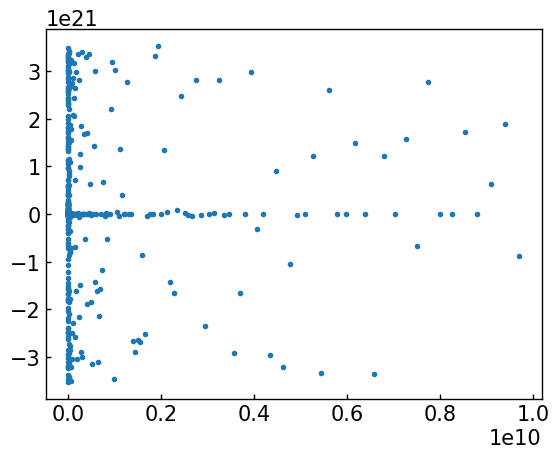

In [299]:
plt.plot(taus_thermal, result_list, ".")

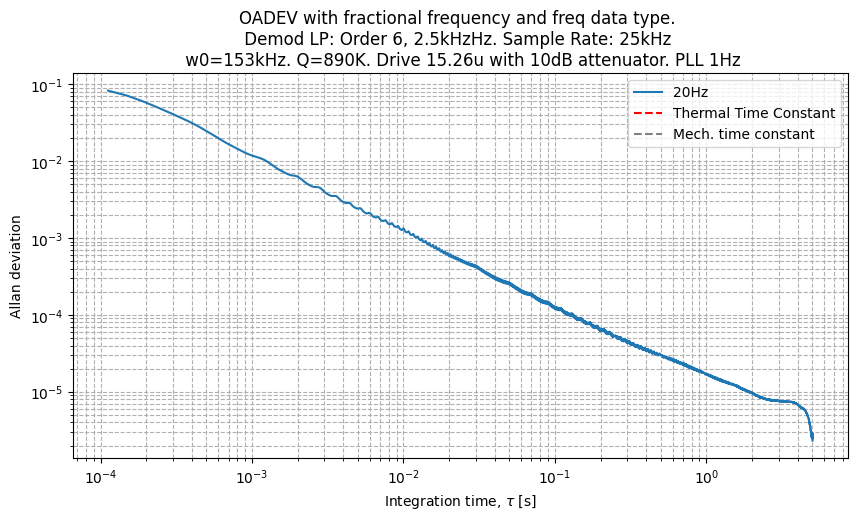

In [11]:
fig = plt.figure(figsize=[10,5]) 
ax = plt.axes()
ax.plot(t2, aldev, "-", label="20Hz")
# ax.plot(t2_noise, aldev_noise, "-", label="Thermo-mechanical noise asymptote for 1.5E-19 Hz^2/Hz")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r'Integration time, $\tau$ [s]')
ax.set_ylabel(r'Allan deviation')
ax.axes.grid(which='both',
             linestyle = '--' )
ax.axes.tick_params(which='both')
#ax.set_title('Frequency stability, 17 kHz, PLL bandwidth ~ 300 Hz')

ax.set_title("OADEV with fractional frequency and freq data type. \n Demod LP: Order 6, 2.5kHzHz. Sample Rate: 25kHz  \n w0=153kHz. Q=890K. Drive 15.26u with 10dB attenuator. PLL 1Hz")
ax.legend()          
# ax.set_ylim(1E-9, 1E-7)

# plt.ylim(1E-9, 1E-7)

plt.vlines(0.055, 1E-9, 1E-7, colors="r", linestyles='--', label='Thermal Time Constant')
# plt.vlines(1/(20*np.pi), 1E-9, 1E-7, colors="k", linestyles='--', label='PLL time constant')
plt.vlines(1.78, 1E-9, 1E-7, colors="grey", linestyles='--', label='Mech. time constant')
plt.legend()

plt.show()

In [91]:
# Calculate Allan variance (ad is squared)

print('started to compute Allan variance')
taus = np.logspace(-1,time_meas,10000)
Data['phase']=np.arctan(Data['y'],Data['x'])

AllanFunction = 'allantools.oadev'   
(t2, ad, ade, adn) = oadev(Data['phase'], rate=Data['rate'], data_type="phase",taus=taus,)
                                   

Data[AllanFunction]={'t2':t2,
                     'av':ad**2 ,
                     'ad':ad,                                   
                     'ade':ade,
                     'adn':adn,
                    }
print('fin')

started to compute Allan variance
fin
